## Inverse Methods Project Workspace
### Eve Chase

In this notebook, I test several implementations of the statistical methodology presented in the paper "Counting and Confusion: Bayesian Rate Estimation with Multiple Populations" by Farr, Gair, Mandel, & Cutler, colloquially known as FGMC.

This methology allows you to infer the rate of astrophysical events (as opposed to noise) detected by gravitational-wave observatories, given a set of triggers with known signal to noise ratios (SNRs). 

In [1]:
import corner
import emcee
import matplotlib.pyplot as plt
import numpy as np
import gwrates.rates_tools as rt
from scipy.special import erfc

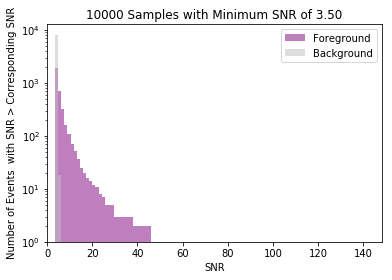

('Number of Foreground: ', 1911)
('Number of Backgruond:', 8089)


In [2]:
# Set known parameters (Example 1 of FGMC paper)
num_samples = 10000
# rate_f = 10.4
# rate_b = 95.1

rate_f = 1930
rate_b = num_samples - rate_f
xmin = 3.5

collection = rt.SampleCollection(rate_f, rate_b, xmin)
collection.draw_samples(num_samples)
collection.plot_hist()
#collection.plot_cdf()


# Check Distributions
Check that the foreground and background distributions correspond to the expected distributions

/Users/scottcoughlin/Documents/virtualenvs/gwrates/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


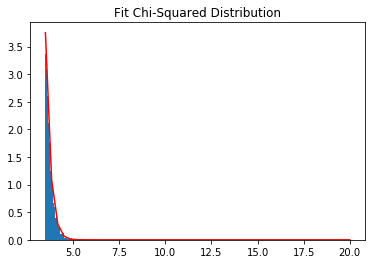

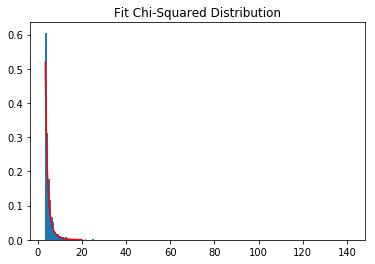

In [3]:
xrange = np.linspace(xmin, 20)

plt.figure()
bins = plt.hist(collection.background, bins=100, normed=True)
plt.plot(xrange, (np.sqrt(np.pi/2) * erfc(xmin / np.sqrt(2)))**(-1) * np.exp(-xrange**2 / 2), 'r')
plt.title('Fit Chi-Squared Distribution')
plt.show()

plt.figure()
bins = plt.hist(collection.foreground, bins=200, normed=True)
plt.plot(xrange, bins[0][0] * 3 * xmin**3 / xrange **4, 'r')
plt.title('Fit Chi-Squared Distribution')
plt.show()

## MCMC
Use an MCMC to with the FGMC methodology to find the underlying rates of foreground and background events.

In [4]:
# Draw from overall samples, assuming we don't know R_f and R_b
all_samples = np.asarray(collection.foreground + collection.background)

pos_true = [rate_f, rate_b]

ndim = 2
nwalkers=100

# Make initial guesses with dimensions (2 x nwalkers) -- FIXME: do this better
pos_init = [100 * np.random.rand(ndim) for i in np.arange(nwalkers)]

np.seterr(invalid='raise')

sampler = emcee.EnsembleSampler(nwalkers, ndim, rt.lnprob, args=[all_samples, xmin])    
sampler.run_mcmc(pos_init, 200)  
post_samples = sampler.chain[:, 50:, :].reshape((-1, ndim))    


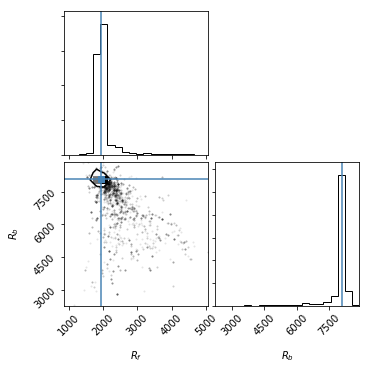

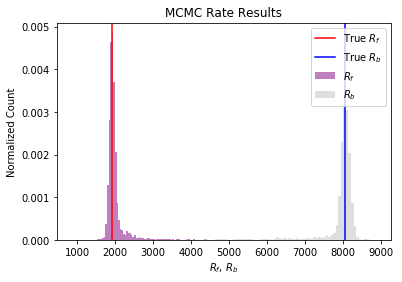

In [5]:
true_f = len(all_samples) * rate_f / (rate_f + rate_b)
true_b = len(all_samples) * rate_b / (rate_f + rate_b)

fig = corner.corner(post_samples, labels=["$R_f$", "$R_b$"], truths=[true_f , true_b])    

# plt.figure()
# plt.plot(sampler.chain[:, 50:, 0], color='k', alpha=0.2)
# plt.show()


# plt.figure()
# plt.plot(sampler.chain[:, 50:, 1], color='k', alpha=0.2, lw=0.5)
# plt.show()


plt.figure()
plt.hist(post_samples[:,0], bins=100, label=r'$R_{f}$', color='purple', alpha=0.5, normed=True)
plt.hist(post_samples[:,1], bins=100, label=r'$R_{b}$', color='0.75', alpha=0.5, normed=True)
plt.axvline(x=true_f, c='r', label=r'True $R_{f}$')
plt.axvline(x=true_b, c='b', label=r'True $R_{b}$')
plt.xlabel(r'$R_f$, $R_b$')
plt.ylabel('Normalized Count')
plt.title('MCMC Rate Results')
plt.legend(loc='upper right')
#plt.xlim(0,140)
plt.show()


## Gravity Spy
In this section, we obtain labels for the excess noise provided by the gravity spy system. Excess noise is identified by the Omicron algorithm that uses wavelets (i.e. sine-gaussians) for identifying excess noise. Therefore, the more a background excess noise event looks like a sine-gaussian the louder the SNR. In addition, restrictions of peak_frequency and SNR were supplied to Gravity Spy data. We only take Omicron triggers with a signal-to-noise ratio of 7.5 and greater and a peak_frequency between 10 and 2048.

These labels will need to be run over with a templated match filter. Of especial interest will be blip and scratch type excess noise.

This effort will be in parallel with finishing a study started so kindly by Laura Nutall and TJ Massinger about comparing omicron and pyCBC match filter values as well as running gravit spy over said events to get a "safety" check of sorts.

Individual Template Example:

https://ldas-jobs.ligo.caltech.edu/~thomas.massinger/detchar/CBC/CBC_Omicron/IMBH-SEOBRv4/IMBH-SEOBNRv4-newSNR-SNR.pdf

All Templates:
https://ldas-jobs.ligo.caltech.edu/~thomas.massinger/detchar/CBC/CBC_Omicron/

This section saves to one h5 file trigger info for human vetted and only machine learning vetted labels. The group is /humn

In [12]:
from gwpy.table import EventTable

# list all possible labels
gravityspy_classes =  ['1080Lines', '1400Ripples', 'Air_Compressor', 'Blip', 
                       'Chirp', 'Extremely_Loud', 'Helix', 'Koi_Fish', 
                       'Light_Modulation', 'Low_Frequency_Burst', 'Low_Frequency_Lines', 
                       'No_Glitch', 'None_of_the_Above', 'Paired_Doves', 'Power_Line', 
                       'Repeating_Blips', 'Scattered_Light', 'Scratchy', 'Tomte', 
                       'Violin_Mode', 'Wandering_Line', 'Whistle']

# Now we determine what types of labels we want: ML or ML + human
label_types = {'human':'Retired', 'machinelearning': '0.9'}

# what metadata do we want
columns = ['snr', 'Label', 'peakGPS']

for iclass in gravityspy_classes:
    for itype in label_types.keys():
        if itype == 'human':
            tmp_table = EventTable.fetch('gravityspy',
                                         'glitches WHERE \"Label\" = \'{0}\' AND \"ImageStatus\" = \'Retired\''.format(
                                             iclass),
                                         columns=columns)
        elif itype == 'machinelearning':
            tmp_table = EventTable.fetch('gravityspy',
                                         'glitches WHERE \"Label\" = \'{0}\' AND \"{0}\" > {1}'.format(
                                             iclass, label_types[itype]),
                                         columns=columns)

        tmp_table['Label'] = tmp_table['Label'].astype(str)
        tmp_table.write('gspytrigger.hdf5', path='{0}/{1}'.format(itype, iclass), format='hdf5', append=True)
